In [15]:
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from typing import TypedDict, Annotated
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
load_dotenv()


True

In [16]:
class State(TypedDict):
    """
    Represents a state with a specific structure defined in a TypedDict.

    Defines the `State` class which incorporates structured data for maintaining
    a state, ensuring compliance with specific annotations to the data.

    :ivar message: A list that holds the message data. The structure of this list
        adheres to annotations specified by the `add_messages`.
    :type message: Annotated[list, add_messages]
    """
    messages: Annotated[list, add_messages]

In [17]:
@tool
def get_stock_price(symbol: str) -> float:
    """return stock price for a given symbol stock symbol
    :param symbol:
    :return:  current stock price
    """
    return {
        "MSFT": 970.3,
        "AAPL": 1506.3,
        "GOOG": 1840.3,
        "AMZN": 899.3,
        "FB": 540.3,
        "TSLA": 870.3
    }.get(symbol, 0.0)


tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.5-flash")
llm_with_tools = llm.bind_tools(tools)

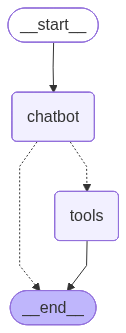

In [18]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
state = graph.invoke({"messages": [{"role": "user", "content": "what is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

1506.3
